In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from annoy import AnnoyIndex
import time

Dataset ini berisi tentang demografi, data kredit, history pembayaran, dan tagihan dari kartu kredit di Taiwan dari APRIL hingga SEPTEMBER 2005.

Sampel pada dataset ini berjumlah 30 ribu baris dan memiliki 24 fitur (dikurangi dengan kolom ID).

Kebanyakan tipe data dari dataset ini berupa interger dan float64

In [3]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# cek
print("Missing values tiap kolom")
print(df.isnull().sum())

Missing values tiap kolom
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [5]:
# normalisai
std = StandardScaler()
cols_to_scale = df.columns.difference(['ID', 'default.payment.next.month'])
df[cols_to_scale] = std.fit_transform(df[cols_to_scale])

In [6]:
# fitur baru ratio
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
df['RATIO'] = df['LIMIT_BAL'] / (df[bill_cols].mean(axis=1) + 1e-6)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,RATIO
0,1,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,...,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1,1.728340
1,2,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,...,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1,0.579229
2,3,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,...,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0,1.414385
3,4,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,...,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0,8.854115
4,5,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,...,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0,2.284943


In [7]:
# seleksi fitur (mencari kelompok pelanggan berdaraskan pola penggunaan)
fitur = [
    'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'RATIO'
]
x = df[fitur]
x.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,RATIO
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1.728340
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,0.579229
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,1.414385
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,8.854115
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,2.284943


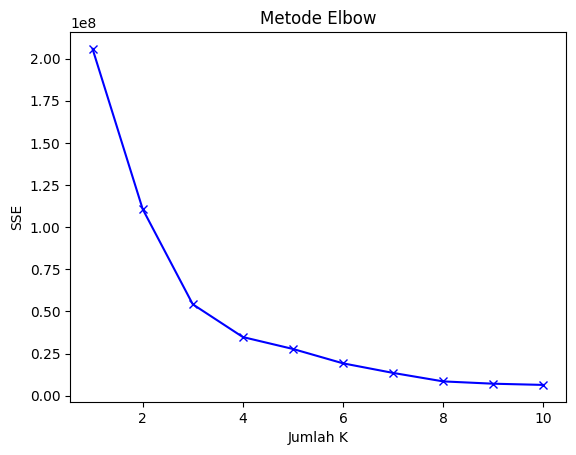

In [8]:
# cari K untuk kmeans
sse = []

k= range(1, 11)
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

plt.plot(k, sse, 'bx-')
plt.xlabel('Jumlah K')
plt.ylabel('SSE')
plt.title('Metode Elbow')
plt.show()

c:\Users\GIO\anaconda3\envs\py312_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


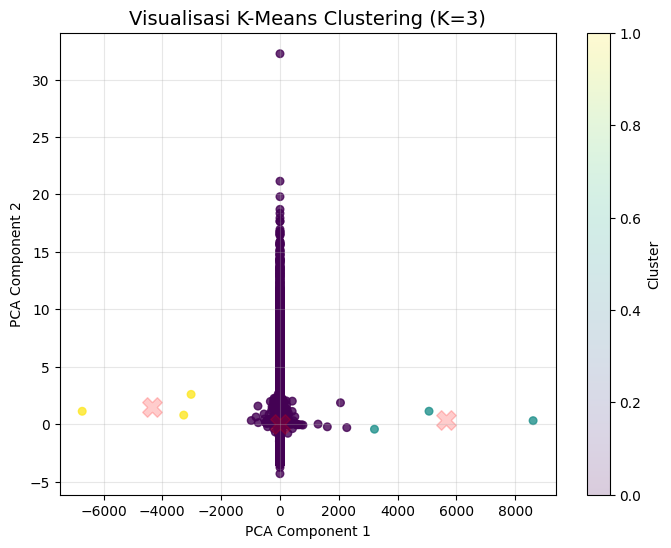

In [9]:
#hasil menunjukkan 3 adalah k terbaik
k=3
kmeans = KMeans(n_clusters=k, random_state=42)

# fit dan prediksi
df['Cluster'] = kmeans.fit_predict(x)

#  Reduksi dimensi menggunakan PCA agar bisa divisualisasikan dalam 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=30, alpha=0.8)
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids', alpha=0.2)
plt.title(f'Visualisasi K-Means Clustering (K={k})', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
print("Jumlah data tiap cluster:")
print(df['Cluster'].value_counts())

Jumlah data tiap cluster:
Cluster
0    29994
2        3
1        3
Name: count, dtype: int64


In [11]:
labels = df['Cluster']
print(f"Silhouette Coefficient: {metrics.silhouette_score(x, labels): .3f}")
print(f"Davies Bouldin Coefficient: {metrics.davies_bouldin_score(x, labels): .3f}")
print("======================================================")

Silhouette Coefficient:  0.997
Davies Bouldin Coefficient:  0.365


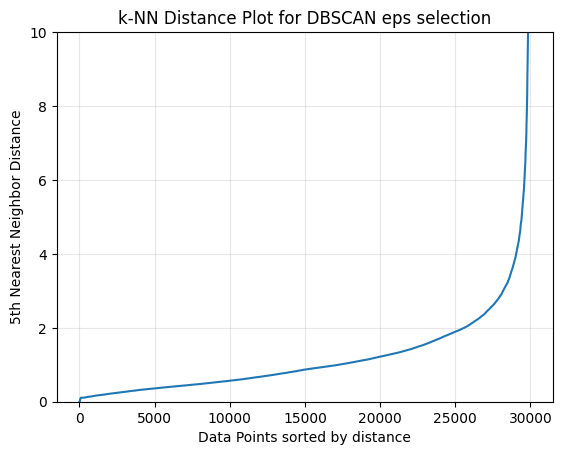

In [12]:
# cari eps unutk dbscan dengan kNN distance plot
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)
distances = np.sort(distances[:,4], axis=0)
plt.plot(distances) 
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('k-NN Distance Plot for DBSCAN eps selection')
plt.ylim(0, 10)
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# DBSCAN
def perbandingan_score_dbscan(eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(x)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print(f"DBSCAN dengan eps={eps} dan min_samples={min_samples}")
    print("estimasi jumlah kluster: %d" % n_clusters_)
    print("estimasi jumlah noise: %d" % n_noise_)
    print(f"Silhouette Coefficient: {metrics.silhouette_score(x, labels): .3f}")
    # siluet max 1
    print(f"Davies Bouldin Coefficient: {metrics.davies_bouldin_score(x, labels): .3f}")
    # davies bouldin lebih baik mendekati 0
    print("======================================================")

perbandingan_score_dbscan(1.5, 5)
perbandingan_score_dbscan(1.5, 10)
perbandingan_score_dbscan(1.5, 15)
perbandingan_score_dbscan(1.5, 20)
perbandingan_score_dbscan(1.5, 25)
perbandingan_score_dbscan(2, 5)
perbandingan_score_dbscan(2, 10)
perbandingan_score_dbscan(2, 15)
perbandingan_score_dbscan(2, 20)
perbandingan_score_dbscan(2, 25)
perbandingan_score_dbscan(2.5, 5)
perbandingan_score_dbscan(2.5, 10)
perbandingan_score_dbscan(2.5, 15)
perbandingan_score_dbscan(2.5, 20)
perbandingan_score_dbscan(2.5, 25)
perbandingan_score_dbscan(3, 5)
perbandingan_score_dbscan(3, 10)
perbandingan_score_dbscan(3, 15)
perbandingan_score_dbscan(3, 20)
perbandingan_score_dbscan(3, 25)

DBSCAN dengan eps=1.5 dan min_samples=5
estimasi jumlah kluster: 78
estimasi jumlah noise: 5955
Silhouette Coefficient: -0.384
Davies Bouldin Coefficient:  4.870
DBSCAN dengan eps=1.5 dan min_samples=10
estimasi jumlah kluster: 45
estimasi jumlah noise: 6928
Silhouette Coefficient: -0.356
Davies Bouldin Coefficient:  5.277
DBSCAN dengan eps=1.5 dan min_samples=15
estimasi jumlah kluster: 39
estimasi jumlah noise: 7645
Silhouette Coefficient: -0.349
Davies Bouldin Coefficient:  5.327
DBSCAN dengan eps=1.5 dan min_samples=20
estimasi jumlah kluster: 31
estimasi jumlah noise: 8315
Silhouette Coefficient: -0.326
Davies Bouldin Coefficient:  5.626
DBSCAN dengan eps=1.5 dan min_samples=25
estimasi jumlah kluster: 29
estimasi jumlah noise: 8830
Silhouette Coefficient: -0.340
Davies Bouldin Coefficient:  5.558
DBSCAN dengan eps=2 dan min_samples=5
estimasi jumlah kluster: 21
estimasi jumlah noise: 3364
Silhouette Coefficient: -0.249
Davies Bouldin Coefficient:  4.325
DBSCAN dengan eps=2 dan mi

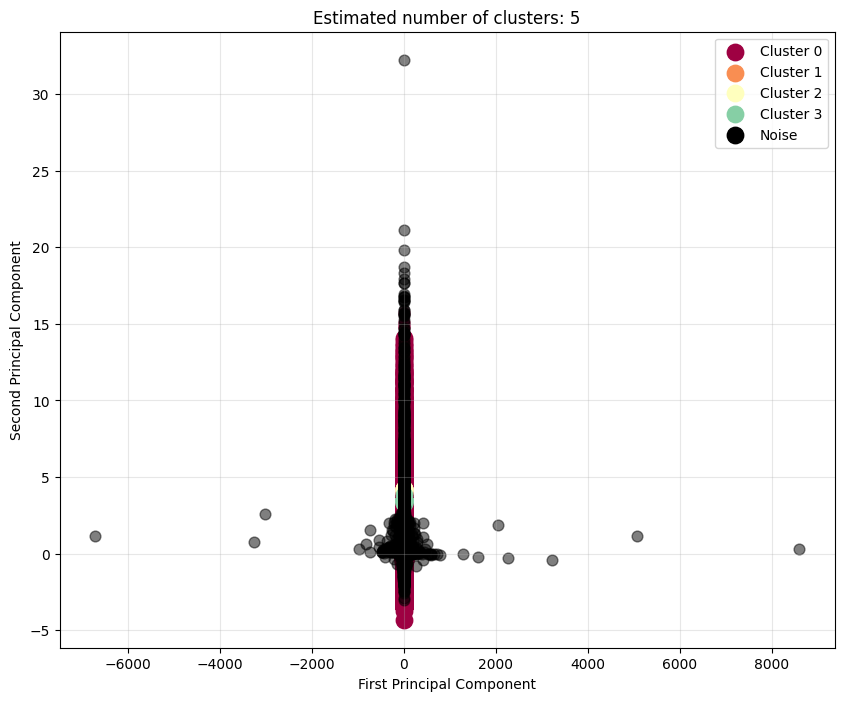

In [14]:
# menggunakan eps 3 dan min_samples 25
db = DBSCAN(eps=3, min_samples=25).fit(x)
df['Cluster_DB'] = db.labels_

labels = df['Cluster_DB']
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x)

# Create scatter plot
plt.figure(figsize=(10, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))

for k, col in zip(set(labels), colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]
    
    class_member_mask = labels == k
    
    # Plot core samples
    xy = pca_result[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], 
                s=140, 
                c=[col], 
                marker='o',
                label=f'Cluster {k}' if k != -1 else 'Noise')
    
    # Plot non-core samples
    xy = pca_result[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], 
                s=60, 
                c=[col], 
                marker='o', 
                alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
import random

x = df[fitur].copy()
data_matrix = x.values.astype('float32') # convert ke float32
n_features = data_matrix.shape[1] # dimensi nya 21

print(f"indeks Annoy dengan {n_features} dimensi")
start = time.time()
t = AnnoyIndex(n_features, 'euclidean')
for i in range(len(data_matrix)):
    t.add_item(i, data_matrix[i])

# 10 tree untuk balancing akurasi dan kecepatan
t.build(10)
print("build done in", time.time() - start, "seconds")

# 5 titik random
num_queries = 5
query_indices = random.sample(range(len(data_matrix)), num_queries)
k_neighbors = 6 # jumlah tetangga terdekat yang dicari

print(f"\nMelakukan Query pada {num_queries} titik acak (mencari {k_neighbors} tetangga terdekat):")

results = {}
for q_idx in query_indices:
    # include_distances=True untuk mendapatkan jarak
    neighbor_indices, distances = t.get_nns_by_item(q_idx, k_neighbors, search_k=-1, include_distances=True)

    # save
    query_results = {
        'neighbor_index': neighbor_indices,
        'distance': distances
    }
    results[q_idx] = query_results

for q_idx, res in results.items():
    print(f"\n--- Query Titik Index: {q_idx} ---")
    print("Vektor Data Awal (head):", x.iloc[q_idx].head().to_dict())
    print(f"Tetangga Terdekat (Index) dan Jarak:")

    # df hasil
    df_results = pd.DataFrame({
        'Index_Tetangga': res['neighbor_index'],
        'Jarak_Euclidean': res['distance'],
        'Cluster_Tetangga': df.loc[res['neighbor_index'], 'Cluster'].values
    })
    # delete entri pertama jika query sendiri (jarak = 0)
    df_results = df_results[df_results['Jarak_Euclidean'] > 1e-6]

    print(df_results)
    


indeks Annoy dengan 21 dimensi
build done in 0.09491944313049316 seconds

Melakukan Query pada 5 titik acak (mencari 6 tetangga terdekat):

--- Query Titik Index: 26145 ---
Vektor Data Awal (head): {'LIMIT_BAL': 0.4818331099937201, 'AGE': 1.3576522914289104, 'PAY_0': 0.01486052289860516, 'PAY_2': 0.11173610381332785, 'PAY_3': 0.13886479544680802}
Tetangga Terdekat (Index) dan Jarak:
   Index_Tetangga  Jarak_Euclidean  Cluster_Tetangga
1           26867         2.033188                 0
2           22792         2.094576                 0
3           18009         2.245838                 0
4           20800         2.270676                 0
5           18247         2.318572                 0

--- Query Titik Index: 3741 ---
Vektor Data Awal (head): {'LIMIT_BAL': -0.982572216860082, 'AGE': 1.249165952268024, 'PAY_0': 0.9047121934737644, 'PAY_2': 1.782348171792314, 'PAY_3': 1.809921299018505}
Tetangga Terdekat (Index) dan Jarak:
   Index_Tetangga  Jarak_Euclidean  Cluster_Tetangga
1  